# Traveling Salesman Problem (TSP) solved with Genetic Algorithms.

The Traveling Salesman Problem is a classic optimization problem that has as objective to calculate the most efficient
way to visit N cities with minimum travelled distance.

We will use a basic genetic algorithm to solve this problem by finding an optimum solution.

Also, we will use the DEAP library to solve this problem, more on this library on the following
[link.](https://deap.readthedocs.io)

## The Algorithm.
First we need some imports:

In [62]:
import os
import pickle
import array
import csv
import codecs
import random
from urllib.request import urlopen
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Then we need to define a function to read the problem data, we will load data from the following site:
[http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/](http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/)

The following function fetch the data from the remote service and parses into a 2-dimensional array. We will use python
serialization to cache the data, so we don't overload the source site with requests.

In [63]:
URL_PREFIX = 'http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/'


def read_tsp_data(tsp_name):
    """
    This function reads the tsp problem sample into an array of coordinates.
    :param tsp_name: the tsp problem name.
    :return: a 2-dimensional array with the city coordinates.
    """
    try:
        locations = pickle.load(open(os.path.join('tsp-data', tsp_name + '-loc.pickle'), 'rb'))
        distances = pickle.load(open(os.path.join('tsp-data', tsp_name + '-dist.pickle'), 'rb'))
        return locations, distances
    except(OSError, IOError):
        pass

    locations = []
    # open url with tsp data
    tsp_url = URL_PREFIX + tsp_name + '.tsp'
    with urlopen(tsp_url) as f:
        # read the data as a csv file delimited with whitespaces (utf-8 character encoding)
        reader = csv.reader(codecs.iterdecode(f, 'utf-8'), delimiter=' ', skipinitialspace=True)
        # ignore all the lines upto the start of the city coordinates
        for row in reader:
            if row[0] in ('DISPLAY_DATA_SECTION', 'NODE_COORD_SECTION'):
                break
        for row in reader:
            # if we reach the end of the data exit
            if row[0] == 'EOF':
                break
            # delete the index, we need the coordinates only
            del row[0]
            locations.append(np.asarray(row, dtype=np.float32))

    # calculate distances using vector norm
    number_cities = len(locations)
    distances = [[0] * number_cities for _ in locations]
    for i in range(number_cities):
        for j in range(i + 1, number_cities):
            # vector norm
            distance = np.linalg.norm(locations[j] - locations[i])
            distances[i][j] = distances[j][i] = distance

    if not os.path.exists('tsp-data'):
        os.makedirs('tsp-data')
    pickle.dump(locations, open(os.path.join('tsp-data', tsp_name + '-loc.pickle'), 'wb'))
    pickle.dump(distances, open(os.path.join('tsp-data', tsp_name + '-dist.pickle'), 'wb'))
    return locations, distances

We will use 29 cities of Bavaria dataset.

In [64]:
CITIES, DISTANCES = read_tsp_data('bayg29')
NUMBER_CITIES = len(CITIES)

We need to define the algorithm hyper-parameters like:
- `NUM_GENERATIONS`: the number of generations that we will iterate applying
genetic algorithm operators to search for new optimal solutions.
- `POPULATION_SIZE`: the population size or how many potential solutions we will
use in each generation of the algorithm.
- `P_CROSSOVER`: the probability for an individual to be selected for crossover (mating)
- `P_MUTATION`: the probability for an individual to be selected for a random
mutation.

In [65]:
NUM_GENERATIONS = 200
POPULATION_SIZE = 100
P_CROSSOVER = 0.9
P_MUTATION = 0.1

Next, we define the algorithm types, first the fitness type that will inherit
from the class `Fitness`, we need a negative weight because we are minimizing
the distance.
Also, we create an individual type, this will inherit from the python `list`
class, because we are going to represent the cities by using an ordered array
of city indexes to represent the solution, for example, if we have `NUMBER_CITIES` cities,
we will have the following as a potential solution:

*NOTE: `individual` refers a particular instance or solution to the problem.*

In [66]:
individual = list(range(NUMBER_CITIES))
individual = random.sample(individual, len(individual))
print(individual)

[17, 12, 2, 21, 20, 11, 8, 25, 13, 4, 3, 19, 7, 1, 18, 28, 22, 24, 10, 26, 23, 14, 6, 16, 5, 9, 15, 27, 0]


Now we can define a function to calculate the distances for a particular
instance of the problem.

In [67]:
def tsp_distance(individual: list) -> float:
    """
    Returns the traveling distance for particular ordering of cities.
    :param individual: an ordered list of cities to visit.
    :return: the total travelled distance.
    """
    # get distance between first and last city
    distance = DISTANCES[individual[0]][individual[-1]]
    # add all other distances
    for i in range(NUMBER_CITIES - 1):
        distance += DISTANCES[individual[i]][individual[i + 1]]
    return distance

Next, we define the `FitnessMin` type that will represent the minimization objective, and an `Individual` type that will
represent an instance or potential solution to this problem.

In [68]:
creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
creator.create('Individual', array.array, typecode='i', fitness=creator.FitnessMin)

/Users/mbassale/devel/genetic-algorithms/venv/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/mbassale/devel/genetic-algorithms/venv/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Also we need to define common operators that will be used to generate the initial population, in this case we need an
operator `randomOrder` that will shuffle an ordered array of cities to generate a new random individual.
The `individualCreator` operator, is called by the `populationCreator` operator to generate each individual and fill the
initial random population.

In [69]:
toolbox = base.Toolbox()
# Create operator to shuffle the cities
toolbox.register('randomOrder', random.sample, range(NUMBER_CITIES), NUMBER_CITIES)
# Create initial random individual operator
toolbox.register('individualCreator', tools.initIterate, creator.Individual, toolbox.randomOrder)
# Create random population operator
toolbox.register('populationCreator', tools.initRepeat, list, toolbox.individualCreator)

Next we define a function that will calculate the fitness of an individual.

In [70]:
def tspFitness(individual) -> tuple:
    return tsp_distance(individual),

Now we define the core operators that will be used on the genetic algorithm:
- `evaluate`: calculates the fitness of an individual.
- `select`: chooses the individuals that will be mated to produce new offspring. In this case we use tournament
selection of three individuals. To know how the tournament selection works, please check the following
[link](https://en.wikipedia.org/wiki/Tournament_selection).
- `mate`: performs the crossover (mating) on the previously selected individuals.
- `mutate`: selects an individual for mutation. The mutation probability is calculated so at least one index is shuffled.

In [71]:
toolbox.register('evaluate', tspFitness)
toolbox.register('select', tools.selTournament, tournsize=3)
toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb=1.0 / NUMBER_CITIES)

Now it's time to generate the initial population.

In [72]:
population = toolbox.populationCreator(n=POPULATION_SIZE)

A `HallOfFame` object is used to store the best individuals of each generation, we will use it to implement elitism by
taking the best individuals from each generation and promoting them to the next generation without applying the genetic
operators.

In [73]:
HALL_OF_FAME_SIZE = 10
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

We use a `Statistics` object to track several statistics of the individuals.

In [74]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register('min', np.min)
stats.register('avg', np.mean)

`Logbook` object is used to track each generation population statistics.

In [75]:
logbook = tools.Logbook()
logbook.header = ['gen', 'nevals'] + stats.fields

Evaluate the individuals with an invalid fitness (all at the beginning)

In [76]:
invalid_individuals = [ind for ind in population if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_individuals)
for ind, fit in zip(invalid_individuals, fitnesses):
    ind.fitness.values = fit

Update the hall of fame object with the initial population.

In [77]:
hof.update(population)
hof_size = len(hof.items)

Calculates statistics for the first generation.

In [78]:
record = stats.compile(population)
logbook.record(gen=0, nevals=len(invalid_individuals), **record)
print(logbook.stream)

gen	nevals	min    	avg    
0  	100   	22441.5	26572.5


Now we are ready to start the genetic flow, iterating and applying the operators to *evolve* and find an optimum
solution.

In [79]:
for gen in range(1, NUM_GENERATIONS + 1):
    # Select the next generation individuals
    offspring = toolbox.select(population, len(population) - hof_size)

    # Vary the pool of individuals
    offspring = algorithms.varAnd(offspring, toolbox, P_CROSSOVER, P_MUTATION)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # add the best back to population:
    offspring.extend(hof.items)

    # Update the hall of fame with the generated individuals
    hof.update(offspring)

    # Replace the current population by the offspring
    population[:] = offspring

    # Append the current generation statistics to the logbook
    record = stats.compile(population) if stats else {}
    logbook.record(gen=gen, nevals=len(invalid_ind), **record)
    print(logbook.stream)


1  	84    	21076  	25252.6
2  	76    	20549.7	23977.6
3  	78    	20549.7	23643.5
4  	84    	20362.2	23007.5
5  	75    	19252.8	22451.4
6  	75    	18302.7	21735.5
7  	85    	18043.9	20945.4
8  	84    	17126.2	20954.1
9  	88    	17003.4	20528.6
10 	84    	17003.4	19738.1
11 	80    	16926.1	19271.9
12 	79    	16133.6	18842.3
13 	89    	15553.2	18352.7
14 	74    	15490.5	18006.5
15 	83    	14413.8	17673.2
16 	81    	14413.8	17298.7
17 	78    	14413.8	17077.7
18 	86    	14258.4	16782.1
19 	79    	14258.4	16452  
20 	74    	13605.2	15981  
21 	80    	13553.1	16029.3
22 	82    	12906.3	15506  
23 	84    	12906.3	15552.1
24 	86    	12726  	15223.5
25 	83    	12560  	14852.1
26 	77    	12146.7	14598.4
27 	74    	12146.7	14287.9
28 	82    	12146.7	14164  
29 	83    	11669.6	13877.6
30 	82    	11659.4	13623.5
31 	82    	11659.4	13512.2
32 	82    	11659.4	13601.3
33 	79    	11569.3	13544.5
34 	86    	11094.8	13114.5
35 	79    	11094.8	13137.8
36 	82    	11094.8	12953.5
37 	75    	11094.8	12760.9
3

Now we can get the best individual from the hall of fame and plot the optimum path.
We can see that about the 90th generation the average and minimum path are very similar, that meas that the algorithm
has converged to an "optimal" solution. We need to take into account that the "optimal" can be a local optima, not the
global optimum.

Best Individual =  Individual('i', [13, 21, 16, 17, 14, 3, 9, 19, 20, 5, 11, 8, 4, 25, 28, 2, 1, 12, 24, 6, 22, 26, 7, 27, 0, 23, 15, 18, 10])
Best Fitness =  9955.779296875


<Figure size 432x288 with 0 Axes>

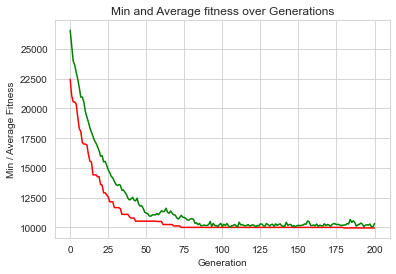

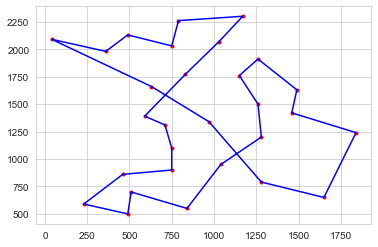

In [82]:
best = hof.items[0]
print('Best Individual = ', best)
print('Best Fitness = ', best.fitness.values[0])
plt.figure(1)

# plot genetic flow statistics:
minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
plt.figure(2)
sns.set_style("whitegrid")
plt.plot(minFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Min / Average Fitness')
plt.title('Min and Average fitness over Generations')
# show both plots:
plt.show()

# now plot the best travelling path.
plt.scatter(*zip(*CITIES), marker='.', color='red')
locs = [CITIES[i] for i in best]
locs.append(locs[0])
plt.plot(*zip(*locs), linestyle='-', color='blue')


## Conclusions
We can draw the following conclusions from this problem.
- The genetic algorithm finds a local optima in about the 90th iteration, we could stop the genetic flow at that moment
when the mean fitness is close to the minimum fitness with some arbitrary epsilon, because that means that
the whole population has converged around a local optima, and the mutation operator will not be able to generate more
diverse individuals that could lead to exploration in other more promising regions of the problem space. If we stop
before, we could save processing resources that are wasted doing unnecessary iterations.
- This algorithm is not parallelized, we could speed up the execution of the genetic flow by using
the python multiprocessing module, threading here will not be very useful because this is a CPU-bound problem, not
IO-bound, so the Python Global Interpreter Lock (GIL) will generate thread contention, while if we choose
multiprocessing we can bypass the GIL and apply the genetic operators in concurrently.
- By using a genetic algorithm we can generate an optimal solution, without investing time learning or implementing a
custom algorithm, that maybe will find the global optima, but it will be tied to this specific problem. With genetic
algorithms we can find a "better" solution by just defining a suitable representation of the TSP problem as an
*individual*.

## Further Experiments
Just for fun we could do the following experiments.
- What happens if we create a genetic algorithms that optimizes the hyper-parameters? We "wrap" this algorithm into a
genetic algorithm that instead optimizes the tournament selection parameter, the crossover parameter, the mutation
parameters, and the number of iterations, so it automatically restarts the genetic flow to search for additional optima
in other parts of the problem space. We can create arrays of different operators implementations, and then apply a
"mutation" by selecting a new operator implementation.
- What happens if we change some operators for some individuals? At generation 30th, we don't mate using two point crossover,
we switch to a new crossover implementation. This could lead to a random-search.
- We could at the end of the genetic flow, increase the mutation parameter and restart the algorithm, so we increase
the chance of finding new local optima in other parts of the problem space.